In [2]:
import torch
from torch.utils.data import Dataset, Subset,DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import nibabel as nib
from pathlib import Path
import numpy as np
from typing import Tuple
import torch.nn as nn
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from models.resnet import resnet10
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from numpy import interp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [45]:
class CustomDataset(Dataset):
    def __init__(self, txt_file, base_dir=Path("."), transform=None):
        self.paths = []
        self.transform = transform

        with open(txt_file, "r") as f:
            for line in f:
                relative_path, label = line.strip().split()
                full_path = base_dir / relative_path
                self.paths.append((full_path, int(label)))

    def __getitem__(self, idx):
        file_path, label = self.paths[idx]
        zstack = nib.load(file_path)
        data = zstack.get_fdata().astype(np.float32)

        # Normalize via log1p and min-max scaling
        data = np.log1p(data)
        data_min, data_max = data.min(), data.max()
        data = (data - data_min) / (data_max - data_min) if data_max > data_min else np.zeros_like(data)

        # Convert to tensor and add channel dimension: (1, D, H, W)
        data = torch.tensor(data).unsqueeze(0)

        # Resize to (1, 32, 256, 256) using trilinear interpolation
        data = torch.nn.functional.interpolate(
            data.unsqueeze(0),  # Add batch dimension: (1, 1, D, H, W)
            size=(32, 256, 256),
            mode='trilinear',
            align_corners=False
        ).squeeze(0)  # Remove batch dimension → (1, 32, 256, 256)

        label = torch.tensor(label, dtype=torch.float32)
        return data, label

    def __len__(self):
        return len(self.paths)

example is path: data/ZStacksWTMUT/images/MUT_0050.nii.gz and its label: 1
Class 1: 238 (50.85%)
Class 0: 230 (49.15%)


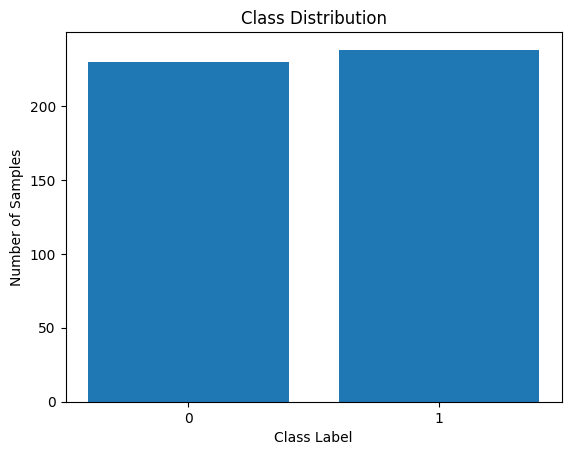

In [4]:
dataset = CustomDataset('data/ZStacksWTMUT/trainval.txt', base_dir=Path("data/ZStacksWTMUT") )

y = [label for _,label in dataset.paths] # path to samples
X = [path for path,label in dataset.paths] # corresponding labels
print(f'example is path: {X[0]} and its label: {y[0]}')


from collections import Counter
class_counts = Counter(y)
total = sum(class_counts.values())
for cls, count in class_counts.items():
    print(f"Class {cls}: {count} ({count / total:.2%})")


plt.bar(class_counts.keys(), class_counts.values())
plt.xticks([0, 1])
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.show()

In [5]:
input_shape = dataset[0][0].shape
print(f'input shape is {input_shape}')

input shape is torch.Size([1, 32, 256, 256])


In [6]:
def training_loop(model, loader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  optimiser: torch.optim.Optimizer,
                  device: torch.device) -> Tuple[float, float]:
    
    model.train()
    train_loss, total_correct, total_samples = 0.0, 0, 0

    for batch, (X, y) in tqdm(enumerate(loader), total=len(loader), desc="Training"):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        y = y.view_as(y_pred)
        loss = loss_fn(y_pred, y)

        train_loss += loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        preds = torch.sigmoid(y_pred) >= 0.5
        correct = (preds == y).sum().item()
        total_correct += correct
        total_samples += y.size(0)

    train_loss /= len(loader)
    train_acc = total_correct / total_samples

    return train_loss, train_acc

In [7]:
def validation_loop(model, loader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module,
                    device: torch.device) -> Tuple[float, float]:
    
    model.eval()
    val_loss, total_correct, total_samples = 0.0, 0, 0

    with torch.no_grad(): 
        for X, y in tqdm(loader, desc='Validation'):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y = y.view_as(y_pred)
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()

            preds = torch.sigmoid(y_pred) >= 0.5
            correct = (preds == y).sum().item()
            total_correct += correct
            total_samples += y.size(0)

    val_loss /= len(loader)
    val_acc = total_correct / total_samples

    return val_loss, val_acc

In [8]:
# loss_fn = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
all_fold_train_losses = []
all_fold_val_losses = []
all_fold_train_accuracies = []
all_fold_val_accuracies = []


per_fold_train_loss_history = {}
per_fold_val_loss_history = {}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
num_epochs = 30

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold+1}")

    train_set = Subset(dataset, train_idx)
    val_set = Subset(dataset, val_idx)
    train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=8, shuffle=False)

    model = resnet10(sample_input_D=32, sample_input_H=256, sample_input_W=256, nclasses=1)

  
    pretrain_weights = "MedicalNet_pytorch_files/pretrain/resnet_10.pth"
    pretrain_model = torch.load(pretrain_weights, map_location=device)
    state_dict = pretrain_model['state_dict']
    new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict, strict=False)

    model = model.to(device)


    for param in model.parameters():
        param.requires_grad = True

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCEWithLogitsLoss()

    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for e in range(num_epochs):
        train_loss, train_acc = training_loop(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_acc = validation_loop(model, val_loader, loss_fn, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {e+1}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_approach2_fold{fold+1}.pth")
        else:
            patience_counter += 1
            print(f"  ↳ No improvement in val_loss ({patience_counter}/{patience})")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    
    all_fold_train_losses.append(train_losses[-1])
    all_fold_val_losses.append(val_losses[-1])
    all_fold_train_accuracies.append(train_accuracies[-1])
    all_fold_val_accuracies.append(val_accuracies[-1])

    per_fold_train_loss_history[f"train_losses_fold{fold+1}"] = train_losses
    per_fold_val_loss_history[f"val_losses_fold{fold+1}"] = val_losses


print("\n===== Cross-Validation Summary =====")
print(f"Avg Train Loss: {np.mean(all_fold_train_losses):.4f}")
print(f"Avg Val Loss:   {np.mean(all_fold_val_losses):.4f}")
print(f"Avg Train Acc:  {np.mean(all_fold_train_accuracies):.4f}")
print(f"Avg Val Acc:    {np.mean(all_fold_val_accuracies):.4f}")


for k in per_fold_train_loss_history:
    print(f"\n{k} = {per_fold_train_loss_history[k]}")
for k in per_fold_val_loss_history:
    print(f"{k} = {per_fold_val_loss_history[k]}")


Fold 1


Validation: 100%|███████████████████████████████| 12/12 [01:54<00:00,  9.58s/it]


Epoch 1: Train Loss: 0.6176, Train Acc: 0.7701 | Val Loss: 0.6031, Val Acc: 0.7766


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.96s/it]


Epoch 2: Train Loss: 0.4500, Train Acc: 0.8984 | Val Loss: 0.2724, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.92s/it]


Epoch 3: Train Loss: 0.2924, Train Acc: 0.9733 | Val Loss: 0.1336, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.85s/it]


Epoch 4: Train Loss: 0.1994, Train Acc: 0.9866 | Val Loss: 0.1357, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.82s/it]


Epoch 5: Train Loss: 0.1444, Train Acc: 0.9866 | Val Loss: 0.0638, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.89s/it]


Epoch 6: Train Loss: 0.1001, Train Acc: 1.0000 | Val Loss: 0.0412, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.86s/it]


Epoch 7: Train Loss: 0.0890, Train Acc: 1.0000 | Val Loss: 0.0200, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.86s/it]


Epoch 8: Train Loss: 0.0601, Train Acc: 0.9973 | Val Loss: 0.0147, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.86s/it]


Epoch 9: Train Loss: 0.0495, Train Acc: 0.9973 | Val Loss: 0.0099, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.89s/it]


Epoch 10: Train Loss: 0.0752, Train Acc: 0.9866 | Val Loss: 0.0061, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.86s/it]


Epoch 11: Train Loss: 0.0363, Train Acc: 1.0000 | Val Loss: 0.0074, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.83s/it]


Epoch 12: Train Loss: 0.0426, Train Acc: 1.0000 | Val Loss: 0.0053, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.88s/it]


Epoch 13: Train Loss: 0.0307, Train Acc: 1.0000 | Val Loss: 0.0045, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.82s/it]


Epoch 14: Train Loss: 0.0577, Train Acc: 0.9840 | Val Loss: 0.0033, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.86s/it]


Epoch 15: Train Loss: 0.0317, Train Acc: 1.0000 | Val Loss: 0.0038, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.85s/it]


Epoch 16: Train Loss: 0.0305, Train Acc: 1.0000 | Val Loss: 0.0034, Val Acc: 1.0000
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.93s/it]


Epoch 17: Train Loss: 0.0567, Train Acc: 0.9759 | Val Loss: 0.0023, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.82s/it]


Epoch 18: Train Loss: 0.0333, Train Acc: 0.9947 | Val Loss: 0.0018, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.86s/it]


Epoch 19: Train Loss: 0.0244, Train Acc: 0.9973 | Val Loss: 0.0024, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.80s/it]


Epoch 20: Train Loss: 0.0176, Train Acc: 1.0000 | Val Loss: 0.0015, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.90s/it]


Epoch 21: Train Loss: 0.0133, Train Acc: 1.0000 | Val Loss: 0.0012, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.83s/it]


Epoch 22: Train Loss: 0.0203, Train Acc: 0.9973 | Val Loss: 0.0009, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.81s/it]


Epoch 23: Train Loss: 0.0128, Train Acc: 1.0000 | Val Loss: 0.0007, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.86s/it]


Epoch 24: Train Loss: 0.0224, Train Acc: 0.9947 | Val Loss: 0.0046, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.78s/it]


Epoch 25: Train Loss: 0.0107, Train Acc: 1.0000 | Val Loss: 0.0009, Val Acc: 1.0000
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.80s/it]


Epoch 26: Train Loss: 0.0744, Train Acc: 0.9679 | Val Loss: 0.0004, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.80s/it]


Epoch 27: Train Loss: 0.0377, Train Acc: 0.9840 | Val Loss: 0.0007, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [15:10<00:00, 75.88s/it]


Epoch 28: Train Loss: 0.0107, Train Acc: 1.0000 | Val Loss: 0.0009, Val Acc: 1.0000
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:41<00:00,  8.44s/it]


Epoch 29: Train Loss: 0.0094, Train Acc: 1.0000 | Val Loss: 0.0010, Val Acc: 1.0000
  ↳ No improvement in val_loss (3/3)
Early stopping triggered.

Fold 2


Validation: 100%|███████████████████████████████| 12/12 [01:40<00:00,  8.41s/it]


Epoch 1: Train Loss: 0.6687, Train Acc: 0.6257 | Val Loss: 0.5957, Val Acc: 0.7447


Validation: 100%|███████████████████████████████| 12/12 [01:41<00:00,  8.48s/it]


Epoch 2: Train Loss: 0.4829, Train Acc: 0.8824 | Val Loss: 0.3280, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [07:58<00:00, 39.89s/it]


Epoch 3: Train Loss: 0.3376, Train Acc: 0.9599 | Val Loss: 0.1559, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:42<00:00,  8.54s/it]


Epoch 4: Train Loss: 0.2436, Train Acc: 0.9679 | Val Loss: 0.1034, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [13:59<00:00, 69.97s/it]


Epoch 5: Train Loss: 0.1287, Train Acc: 0.9973 | Val Loss: 0.0576, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [19:04<00:00, 95.39s/it]


Epoch 6: Train Loss: 0.1174, Train Acc: 0.9947 | Val Loss: 0.0363, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:54<00:00,  9.53s/it]


Epoch 7: Train Loss: 0.0917, Train Acc: 0.9973 | Val Loss: 0.0244, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:50<00:00,  9.17s/it]


Epoch 8: Train Loss: 0.0610, Train Acc: 1.0000 | Val Loss: 0.0167, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:50<00:00,  9.24s/it]


Epoch 9: Train Loss: 0.0670, Train Acc: 0.9840 | Val Loss: 0.0287, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:49<00:00,  9.12s/it]


Epoch 10: Train Loss: 0.0472, Train Acc: 1.0000 | Val Loss: 0.0107, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.69s/it]


Epoch 11: Train Loss: 0.0400, Train Acc: 0.9973 | Val Loss: 0.0098, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.79s/it]


Epoch 12: Train Loss: 0.0234, Train Acc: 1.0000 | Val Loss: 0.0057, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.77s/it]


Epoch 13: Train Loss: 0.0355, Train Acc: 1.0000 | Val Loss: 0.0058, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.81s/it]


Epoch 14: Train Loss: 0.0260, Train Acc: 1.0000 | Val Loss: 0.0054, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.80s/it]


Epoch 15: Train Loss: 0.0193, Train Acc: 1.0000 | Val Loss: 0.0036, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [10:39<00:00, 53.25s/it]


Epoch 16: Train Loss: 0.0224, Train Acc: 1.0000 | Val Loss: 0.0050, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.82s/it]


Epoch 17: Train Loss: 0.0248, Train Acc: 1.0000 | Val Loss: 0.0031, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.75s/it]


Epoch 18: Train Loss: 0.0115, Train Acc: 1.0000 | Val Loss: 0.0021, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:51<00:00,  9.32s/it]


Epoch 19: Train Loss: 0.0121, Train Acc: 1.0000 | Val Loss: 0.0026, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:53<00:00,  9.42s/it]


Epoch 20: Train Loss: 0.0146, Train Acc: 1.0000 | Val Loss: 0.0026, Val Acc: 1.0000
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:50<00:00,  9.22s/it]


Epoch 21: Train Loss: 0.0497, Train Acc: 0.9840 | Val Loss: 0.0016, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:51<00:00,  9.27s/it]


Epoch 22: Train Loss: 0.0128, Train Acc: 1.0000 | Val Loss: 0.0013, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:49<00:00,  9.11s/it]


Epoch 23: Train Loss: 0.0147, Train Acc: 1.0000 | Val Loss: 0.0011, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.03s/it]


Epoch 24: Train Loss: 0.0449, Train Acc: 0.9840 | Val Loss: 0.0042, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.77s/it]


Epoch 25: Train Loss: 0.0212, Train Acc: 1.0000 | Val Loss: 0.0020, Val Acc: 1.0000
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.79s/it]


Epoch 26: Train Loss: 0.0418, Train Acc: 0.9893 | Val Loss: 0.0007, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.84s/it]


Epoch 27: Train Loss: 0.0783, Train Acc: 0.9733 | Val Loss: 0.0058, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.82s/it]


Epoch 28: Train Loss: 0.0100, Train Acc: 1.0000 | Val Loss: 0.0008, Val Acc: 1.0000
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.79s/it]


Epoch 29: Train Loss: 0.0113, Train Acc: 1.0000 | Val Loss: 0.0007, Val Acc: 1.0000
  ↳ No improvement in val_loss (3/3)
Early stopping triggered.

Fold 3


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.80s/it]


Epoch 1: Train Loss: 0.6473, Train Acc: 0.6765 | Val Loss: 0.6276, Val Acc: 0.7766


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.80s/it]


Epoch 2: Train Loss: 0.5183, Train Acc: 0.7807 | Val Loss: 0.4139, Val Acc: 0.7766


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.82s/it]


Epoch 3: Train Loss: 0.3925, Train Acc: 0.8396 | Val Loss: 0.3193, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.99s/it]


Epoch 4: Train Loss: 0.2640, Train Acc: 0.9572 | Val Loss: 0.2003, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.87s/it]


Epoch 5: Train Loss: 0.1666, Train Acc: 0.9840 | Val Loss: 0.0829, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.88s/it]


Epoch 6: Train Loss: 0.1149, Train Acc: 0.9893 | Val Loss: 0.0655, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.82s/it]


Epoch 7: Train Loss: 0.0722, Train Acc: 0.9973 | Val Loss: 0.0260, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.63s/it]


Epoch 8: Train Loss: 0.0530, Train Acc: 1.0000 | Val Loss: 0.0252, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.73s/it]


Epoch 9: Train Loss: 0.0378, Train Acc: 1.0000 | Val Loss: 0.0155, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:42<00:00,  8.56s/it]


Epoch 10: Train Loss: 0.0430, Train Acc: 1.0000 | Val Loss: 0.0203, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.78s/it]


Epoch 11: Train Loss: 0.0392, Train Acc: 0.9973 | Val Loss: 0.1881, Val Acc: 0.9574
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.79s/it]


Epoch 12: Train Loss: 0.0221, Train Acc: 1.0000 | Val Loss: 0.0065, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.93s/it]


Epoch 13: Train Loss: 0.0174, Train Acc: 1.0000 | Val Loss: 0.0072, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.73s/it]


Epoch 14: Train Loss: 0.0349, Train Acc: 0.9973 | Val Loss: 0.0023, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.81s/it]


Epoch 15: Train Loss: 0.0161, Train Acc: 1.0000 | Val Loss: 0.0069, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.71s/it]


Epoch 16: Train Loss: 0.0122, Train Acc: 1.0000 | Val Loss: 0.0028, Val Acc: 1.0000
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.78s/it]


Epoch 17: Train Loss: 0.0133, Train Acc: 1.0000 | Val Loss: 0.0031, Val Acc: 1.0000
  ↳ No improvement in val_loss (3/3)
Early stopping triggered.

Fold 4


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.65s/it]


Epoch 1: Train Loss: 0.6266, Train Acc: 0.7093 | Val Loss: 0.5617, Val Acc: 0.7204


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.72s/it]


Epoch 2: Train Loss: 0.4456, Train Acc: 0.8853 | Val Loss: 0.2622, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.63s/it]


Epoch 3: Train Loss: 0.3117, Train Acc: 0.9387 | Val Loss: 0.1565, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.66s/it]


Epoch 4: Train Loss: 0.2137, Train Acc: 0.9707 | Val Loss: 0.0830, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.72s/it]


Epoch 5: Train Loss: 0.1622, Train Acc: 0.9733 | Val Loss: 0.0605, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.77s/it]


Epoch 6: Train Loss: 0.1015, Train Acc: 0.9947 | Val Loss: 0.0338, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.74s/it]


Epoch 7: Train Loss: 0.0831, Train Acc: 1.0000 | Val Loss: 0.0390, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.67s/it]


Epoch 8: Train Loss: 0.1105, Train Acc: 0.9840 | Val Loss: 0.0154, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.61s/it]


Epoch 9: Train Loss: 0.0836, Train Acc: 0.9787 | Val Loss: 0.0124, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.87s/it]


Epoch 10: Train Loss: 0.0530, Train Acc: 0.9973 | Val Loss: 0.0068, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:49<00:00,  9.15s/it]


Epoch 11: Train Loss: 0.0345, Train Acc: 0.9973 | Val Loss: 0.0057, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:51<00:00,  9.31s/it]


Epoch 12: Train Loss: 0.0334, Train Acc: 1.0000 | Val Loss: 0.0069, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:51<00:00,  9.32s/it]


Epoch 13: Train Loss: 0.0536, Train Acc: 0.9920 | Val Loss: 0.0039, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:49<00:00,  9.12s/it]


Epoch 14: Train Loss: 0.0260, Train Acc: 1.0000 | Val Loss: 0.0022, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.67s/it]


Epoch 15: Train Loss: 0.0411, Train Acc: 0.9973 | Val Loss: 0.0026, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:49<00:00,  9.13s/it]


Epoch 16: Train Loss: 0.0389, Train Acc: 0.9947 | Val Loss: 0.0026, Val Acc: 1.0000
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.74s/it]


Epoch 17: Train Loss: 0.0333, Train Acc: 0.9973 | Val Loss: 0.0014, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.63s/it]


Epoch 18: Train Loss: 0.0139, Train Acc: 1.0000 | Val Loss: 0.0042, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.63s/it]


Epoch 19: Train Loss: 0.0286, Train Acc: 0.9973 | Val Loss: 0.0011, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.71s/it]


Epoch 20: Train Loss: 0.0101, Train Acc: 1.0000 | Val Loss: 0.0014, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.65s/it]


Epoch 21: Train Loss: 0.0428, Train Acc: 0.9920 | Val Loss: 0.0027, Val Acc: 1.0000
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:50<00:00,  9.23s/it]


Epoch 22: Train Loss: 0.0236, Train Acc: 1.0000 | Val Loss: 0.0011, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.76s/it]


Epoch 23: Train Loss: 0.0177, Train Acc: 1.0000 | Val Loss: 0.0014, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:47<00:00,  8.98s/it]


Epoch 24: Train Loss: 0.0336, Train Acc: 0.9947 | Val Loss: 0.0019, Val Acc: 1.0000
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.86s/it]


Epoch 25: Train Loss: 0.0449, Train Acc: 0.9893 | Val Loss: 0.0010, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.05s/it]


Epoch 26: Train Loss: 0.0114, Train Acc: 1.0000 | Val Loss: 0.0013, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:50<00:00,  9.23s/it]


Epoch 27: Train Loss: 0.0078, Train Acc: 1.0000 | Val Loss: 0.0010, Val Acc: 1.0000
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.76s/it]


Epoch 28: Train Loss: 0.0062, Train Acc: 1.0000 | Val Loss: 0.0011, Val Acc: 1.0000
  ↳ No improvement in val_loss (3/3)
Early stopping triggered.

Fold 5


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.86s/it]


Epoch 1: Train Loss: 0.6386, Train Acc: 0.5920 | Val Loss: 0.6374, Val Acc: 0.5054


Validation: 100%|███████████████████████████████| 12/12 [01:46<00:00,  8.86s/it]


Epoch 2: Train Loss: 0.4656, Train Acc: 0.7973 | Val Loss: 0.3462, Val Acc: 0.8065


Validation: 100%|███████████████████████████████| 12/12 [01:48<00:00,  9.02s/it]


Epoch 3: Train Loss: 0.3683, Train Acc: 0.8827 | Val Loss: 0.2549, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:52<00:00,  9.34s/it]


Epoch 4: Train Loss: 0.2320, Train Acc: 0.9760 | Val Loss: 0.1541, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.75s/it]


Epoch 5: Train Loss: 0.1488, Train Acc: 0.9920 | Val Loss: 0.1314, Val Acc: 0.9892


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.73s/it]


Epoch 6: Train Loss: 0.1366, Train Acc: 0.9893 | Val Loss: 0.0407, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.68s/it]


Epoch 7: Train Loss: 0.0676, Train Acc: 1.0000 | Val Loss: 0.0314, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.72s/it]


Epoch 8: Train Loss: 0.0619, Train Acc: 0.9947 | Val Loss: 0.0160, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.65s/it]


Epoch 9: Train Loss: 0.0509, Train Acc: 1.0000 | Val Loss: 0.0167, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.65s/it]


Epoch 10: Train Loss: 0.0430, Train Acc: 0.9973 | Val Loss: 0.0114, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.69s/it]


Epoch 11: Train Loss: 0.0303, Train Acc: 1.0000 | Val Loss: 0.0067, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.67s/it]


Epoch 12: Train Loss: 0.0341, Train Acc: 1.0000 | Val Loss: 0.0077, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.61s/it]


Epoch 13: Train Loss: 0.0277, Train Acc: 1.0000 | Val Loss: 0.0034, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:44<00:00,  8.70s/it]


Epoch 14: Train Loss: 0.0259, Train Acc: 1.0000 | Val Loss: 0.0028, Val Acc: 1.0000


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.63s/it]


Epoch 15: Train Loss: 0.0234, Train Acc: 1.0000 | Val Loss: 0.0136, Val Acc: 1.0000
  ↳ No improvement in val_loss (1/3)


Validation: 100%|███████████████████████████████| 12/12 [01:45<00:00,  8.77s/it]


Epoch 16: Train Loss: 0.0397, Train Acc: 0.9893 | Val Loss: 0.0036, Val Acc: 1.0000
  ↳ No improvement in val_loss (2/3)


Validation: 100%|███████████████████████████████| 12/12 [01:43<00:00,  8.65s/it]

Epoch 17: Train Loss: 0.0491, Train Acc: 0.9947 | Val Loss: 0.0073, Val Acc: 1.0000
  ↳ No improvement in val_loss (3/3)
Early stopping triggered.

===== Cross-Validation Summary =====
Avg Train Loss: 0.0179
Avg Val Loss:   0.0026
Avg Train Acc:  0.9989
Avg Val Acc:    1.0000

train_losses_fold1 = [0.6176061617567185, 0.4500378319557677, 0.29243820715457836, 0.19944189552296984, 0.14436512876381266, 0.10014128772185203, 0.08900764533021349, 0.06014033739871167, 0.04950284765676615, 0.07518097587880936, 0.03628695142911153, 0.04263609828070757, 0.030664141894258718, 0.057724876794964075, 0.03170165359141662, 0.03052690232846331, 0.05669730662942884, 0.03326683979917397, 0.02442860084665107, 0.01758488057121793, 0.013345161457843285, 0.020313746055607942, 0.012842610820216383, 0.02242524144388339, 0.010735732550296853, 0.07439367033471848, 0.03772192082040884, 0.010717346516259491, 0.009393313638321025]

train_losses_fold2 = [0.668664129490548, 0.4828578601492212, 0.33757157940813837, 0.

Fold 1: 100%|███████████████████████████████████| 25/25 [00:29<00:00,  1.17s/it]



Fold 1 Results:
  Accuracy  : 1.0000
  Precision : 1.0000
  Recall    : 1.0000
  F1 Score  : 1.0000
  ROC AUC   : 1.0000


Fold 2: 100%|███████████████████████████████████| 25/25 [00:28<00:00,  1.16s/it]



Fold 2 Results:
  Accuracy  : 1.0000
  Precision : 1.0000
  Recall    : 1.0000
  F1 Score  : 1.0000
  ROC AUC   : 1.0000


Fold 3: 100%|███████████████████████████████████| 25/25 [00:28<00:00,  1.14s/it]



Fold 3 Results:
  Accuracy  : 1.0000
  Precision : 1.0000
  Recall    : 1.0000
  F1 Score  : 1.0000
  ROC AUC   : 1.0000


Fold 4: 100%|███████████████████████████████████| 25/25 [00:29<00:00,  1.16s/it]



Fold 4 Results:
  Accuracy  : 1.0000
  Precision : 1.0000
  Recall    : 1.0000
  F1 Score  : 1.0000
  ROC AUC   : 1.0000


Fold 5: 100%|███████████████████████████████████| 25/25 [00:29<00:00,  1.17s/it]



Fold 5 Results:
  Accuracy  : 1.0000
  Precision : 1.0000
  Recall    : 1.0000
  F1 Score  : 1.0000
  ROC AUC   : 1.0000

===== Cross-Fold Test Summary =====
Accuracy  : 1.0000 ± 0.0000
Precision : 1.0000 ± 0.0000
Recall    : 1.0000 ± 0.0000
F1        : 1.0000 ± 0.0000
Roc_auc   : 1.0000 ± 0.0000


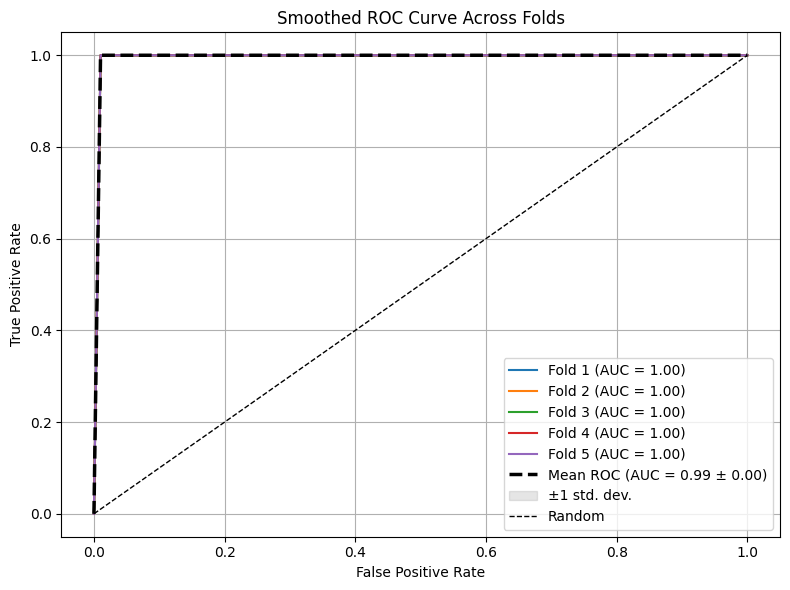

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of best model files for each fold
model_paths = [
    "best_model_approach2_fold1.pth",
    "best_model_approach2_fold2.pth",
    "best_model_approach2_fold3.pth",
    "best_model_approach2_fold4.pth",
    "best_model_approach2_fold5.pth"
]

# Set up test dataset
test_set = CustomDataset('data/ZStacksWTMUT/test.txt', base_dir=Path("data/ZStacksWTMUT"))
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

# Store metrics and ROC data
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': []
}
roc_data = []

for fold, model_path in enumerate(model_paths, 1):
    model = resnet10(sample_input_D=32, sample_input_H=256, sample_input_W=256, nclasses=1)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Fold {fold}"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.sigmoid(outputs).view(-1)
            preds = (probs > 0.5).int()

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)

    # Store for plotting
    roc_data.append((fpr, tpr, roc_auc))

    print(f"\nFold {fold} Results:")
    print(f"  Accuracy  : {acc:.4f}")
    print(f"  Precision : {prec:.4f}")
    print(f"  Recall    : {rec:.4f}")
    print(f"  F1 Score  : {f1:.4f}")
    print(f"  ROC AUC   : {roc_auc:.4f}")

    metrics['accuracy'].append(acc)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['f1'].append(f1)
    metrics['roc_auc'].append(roc_auc)

# Print summary
print("\n===== Cross-Fold Test Summary =====")
for key in metrics:
    mean = np.mean(metrics[key])
    std = np.std(metrics[key])
    print(f"{key.capitalize():<10}: {mean:.4f} ± {std:.4f}")

mean_fpr = np.linspace(0, 1, 100)
tprs, aucs = [], []

plt.figure(figsize=(8, 6))

for i, (fpr, tpr, roc_auc) in enumerate(roc_data):
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    plt.plot(mean_fpr, interp_tpr, lw=1.5, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--',
         label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2.5)
plt.fill_between(mean_fpr, np.maximum(mean_tpr - std_tpr, 0), np.minimum(mean_tpr + std_tpr, 1),
                 color='grey', alpha=0.2, label='±1 std. dev.')

plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Smoothed ROC Curve Across Folds')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_smoothed_all_folds.png', dpi=300)
plt.show()